# Convolutional autoencoder for image denoising

This example demonstrates how to implement a deep convolutional autoencoder for image denoising, mapping noisy digits images from the cifar10 dataset to clean images.

## First iteration 
#### We start from the same model as it is stated in this article https://keras.io/examples/vision/autoencoder/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models
from keras.datasets import cifar10
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import cv2

In [3]:
def preprocess(array):
    """Normalizes the supplied array."""
    array = array.astype("float32") / 255.0
    return array

def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape)
    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
# Load CIFAR-10 dataset
(train_data, _), (test_data, _) = cifar10.load_data()

In [5]:
# Normalize the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

In [6]:
# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

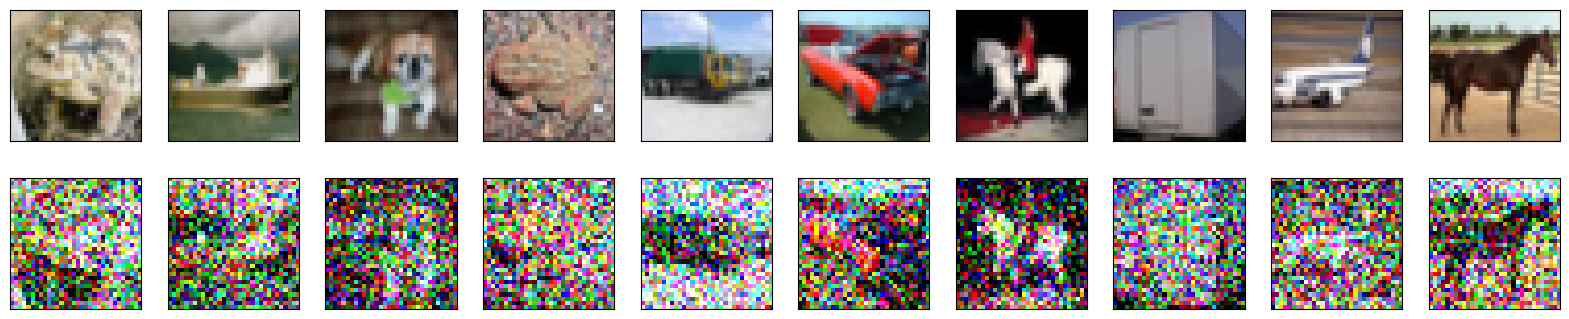

In [7]:
# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [12]:
# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

In [13]:
# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

In [14]:
# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

In [26]:
# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       9248

In [31]:
# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=25, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Epoch 1/25
391/391 [==============================] - 42s 107ms/step - loss: 0.5684 - val_loss: 0.5692
Epoch 2/25
391/391 [==============================] - 39s 101ms/step - loss: 0.5684 - val_loss: 0.5695
Epoch 3/25
391/391 [==============================] - 38s 98ms/step - loss: 0.5684 - val_loss: 0.5698
Epoch 4/25
391/391 [==============================] - 40s 103ms/step - loss: 0.5684 - val_loss: 0.5694
Epoch 5/25
391/391 [==============================] - 45s 115ms/step - loss: 0.5684 - val_loss: 0.5694
Epoch 6/25
391/391 [==============================] - 40s 103ms/step - loss: 0.5684 - val_loss: 0.5695
Epoch 7/25
391/391 [==============================] - 41s 105ms/step - loss: 0.5684 - val_loss: 0.5692
Epoch 8/25
391/391 [==============================] - 44s 113ms/step - loss: 0.5684 - val_loss: 0.5697
Epoch 9/25
391/391 [==============================] - 44s 112ms/step - loss: 0.5684 - val_loss: 0.5693
Epoch 10/25
391/391 [==============================] - 45s 116ms/step - lo

In [32]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

313/313 [==============================] - 4s 13ms/step


##### Conclusions 
We got pretty good results, visually close to the original images of the dataset

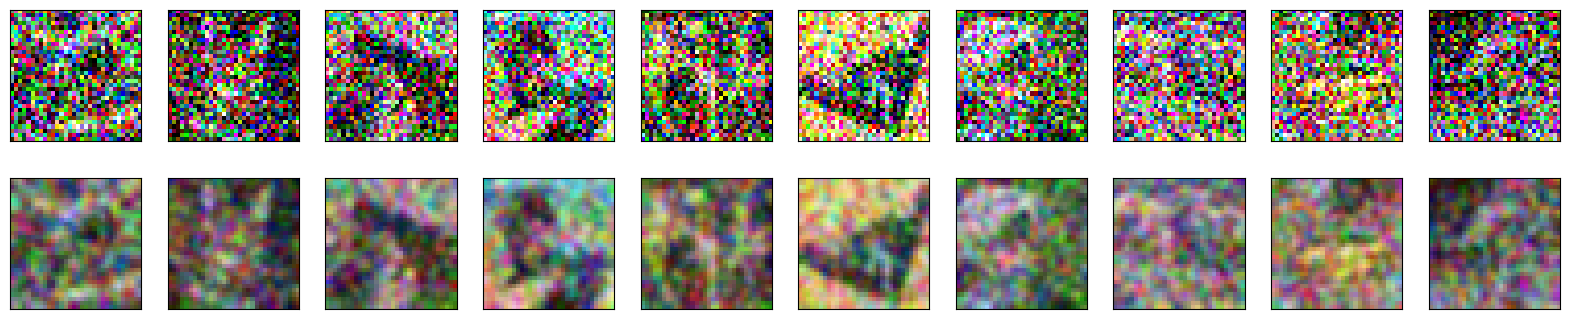

In [10]:
# Apply Gaussian filtering
def gaussian_denoise(array):
    denoised_array = np.zeros(array.shape)
    for i in range(array.shape[0]):
        for j in range(array.shape[3]):
            denoised_array[i, :, :, j] = cv2.GaussianBlur(array[i, :, :, j], (3, 3), 0)
    return denoised_array

gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

It is obvious, Gaussian filtering works much worse

In [33]:
# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

Autoencoder MSE: 0.008171512745320797
Gaussian Filter MSE: 0.020652590831253922


### First iteration conclusion
The encoder works much better than Gaussian Filter, which is very-well presented by visual results and mean squared error. 

## Second Iteration
Let's add more layers and change number of epochs (35 instead of 25)

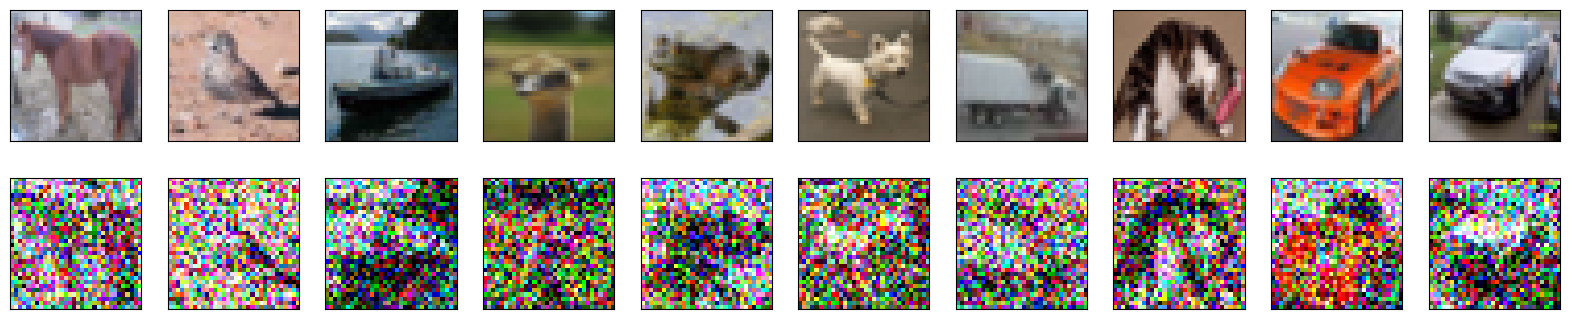

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 64)          3692

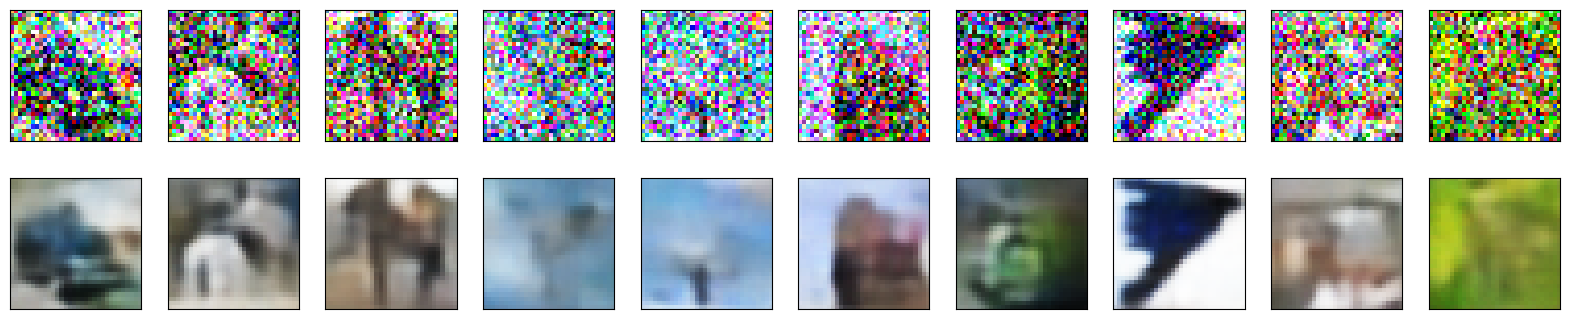

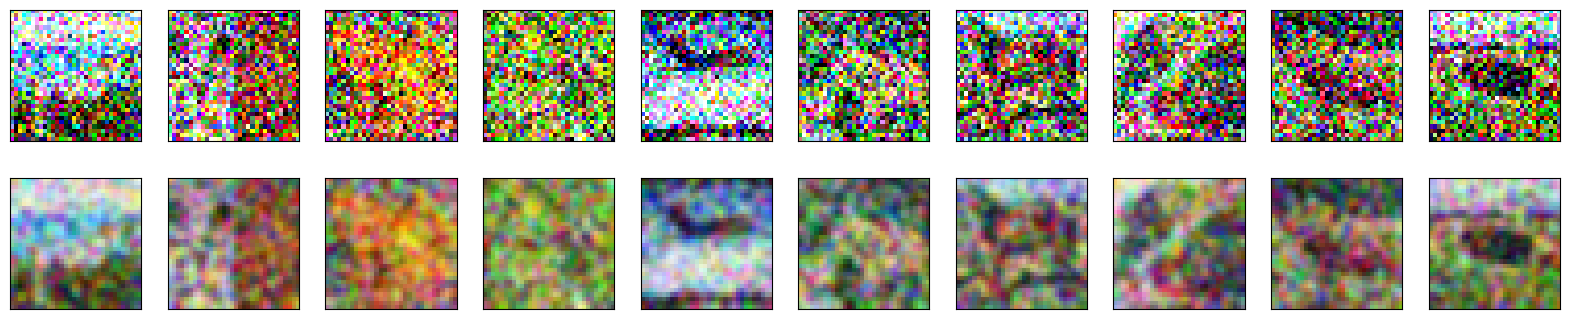

Autoencoder MSE: 0.009152798913419247
Gaussian Filter MSE: 0.02064421118439357


In [36]:
# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=35, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
def gaussian_denoise(array):
    denoised_array = np.zeros(array.shape)
    for i in range(array.shape[0]):
        for j in range(array.shape[3]):
            denoised_array[i, :, :, j] = cv2.GaussianBlur(array[i, :, :, j], (3, 3), 0)
    return denoised_array

gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

### Results for Second Iteration
The model still performs well, but worse than before. An increase in amount of layers and epochs didn't help

## Third iteration
Here we'll try to add also batch normalization and dropout. Additionally, we'll increase the number of filters

In [27]:
# Define the improved autoencoder model with Dropout
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=20, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))



Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 16, 16, 128)       7385

313/313 [==============================] - 8s 23ms/step


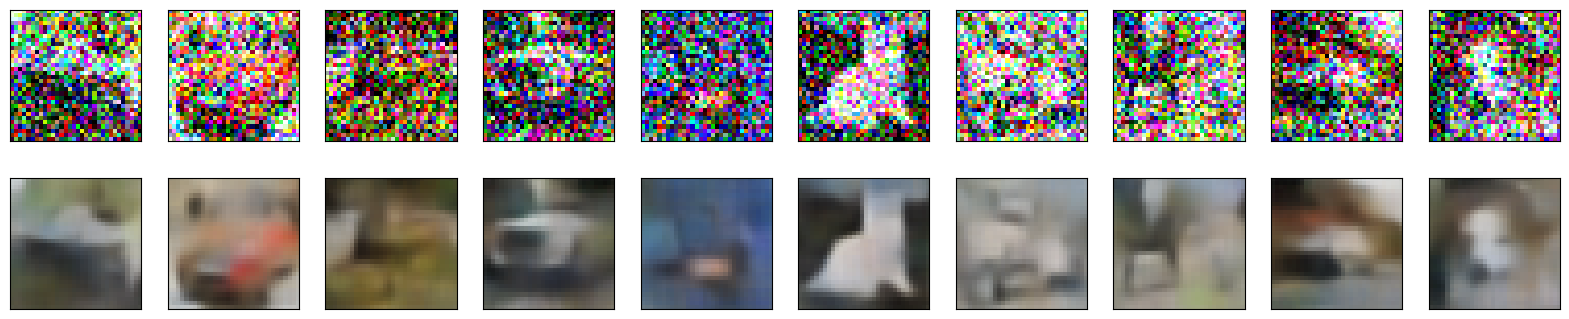

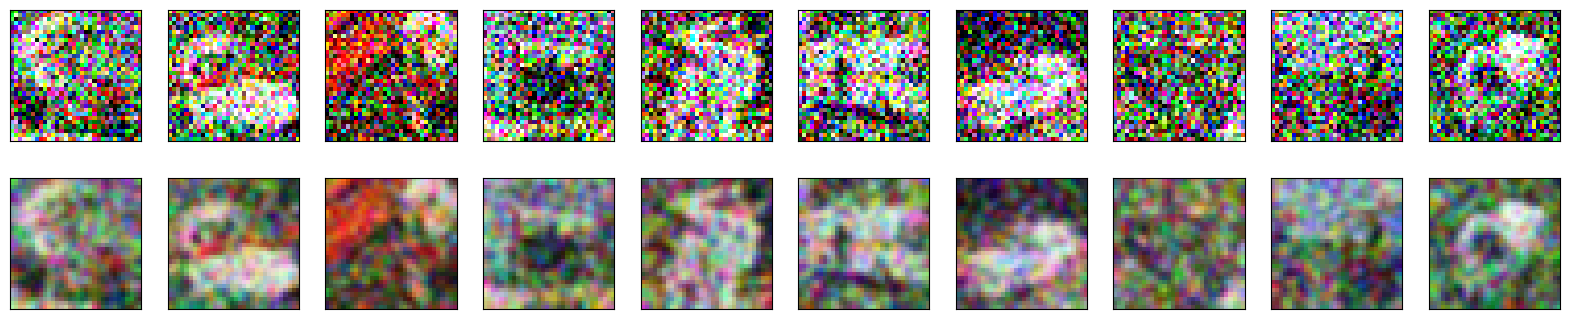

Dropout Autoencoder MSE: 0.01290878839790821
Gaussian Filter MSE: 0.020629242757988924


In [28]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

### Third iteration result 
Surprisingly, it's worse than previous options. Probably, because a number of epochs is not great, but training takes to long to pass more epochs.

## Fourth iteration
Here we'll try to reduce the number of filters in comparison to the previous option. This will allow us to increase the number of epochs.

In [29]:
# Define the improved autoencoder model with Dropout
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=30, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_28 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        184

313/313 [==============================] - 4s 12ms/step


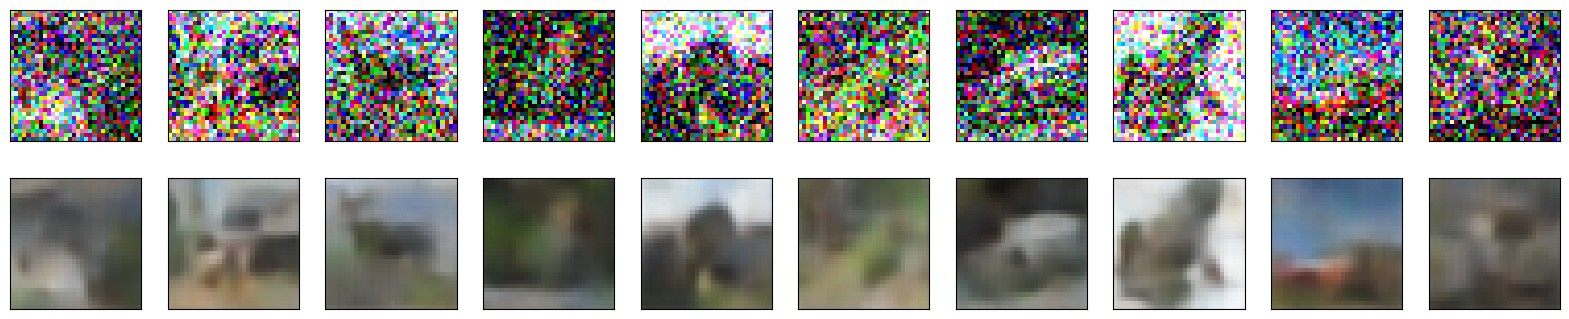

Dropout Autoencoder MSE: 0.012995339930057526
Gaussian Filter MSE: 0.020629242757988924


In [30]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

### Fourth iteration result 
Surprisingly, it's still worse than the previous options. Even with the increase in a number of epochs.

## Fifth iteration
Here we'll try to reduce the number of filters even more while increasing number of epochs.

In [31]:
# Define the improved autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=40, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_32 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_33 (Bat  (None, 16, 16, 32)       128

In [32]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

313/313 [==============================] - 3s 9ms/step


Dropout Autoencoder MSE: 0.008244398050010204
Gaussian Filter MSE: 0.020629242757988924


### Fifth iteration result 
It is almost as good as the first iteration, but still not better.

## Sixth iteration
Let's get back to roots and use original architecture, but with more epochs.

In [13]:
# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=50, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 32)       9248

313/313 [==============================] - 3s 9ms/step


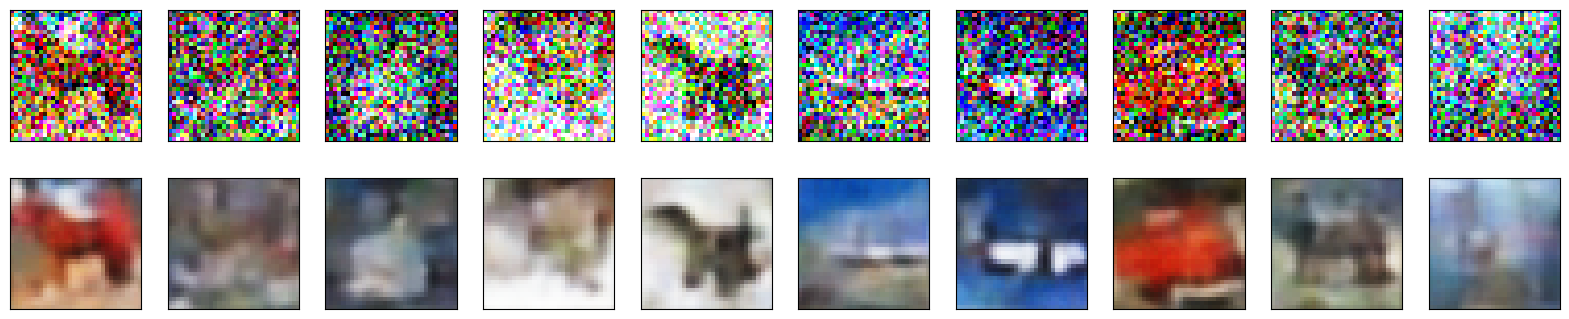

Dropout Autoencoder MSE: 0.008790838532149792
Gaussian Filter MSE: 0.020629242757988924


In [14]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

### Sixth iteration result 
It is almost as good as the first iteration, but still not better. Number of epochs didn't help in this case.

## Seventh iteration
Let's try different optimizer for the encoder. We were using adam, now it will be RMSprop

In [18]:
from keras.optimizers import RMSprop

# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=RMSprop(), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=25, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 16, 16, 32)       9248

313/313 [==============================] - 3s 8ms/step


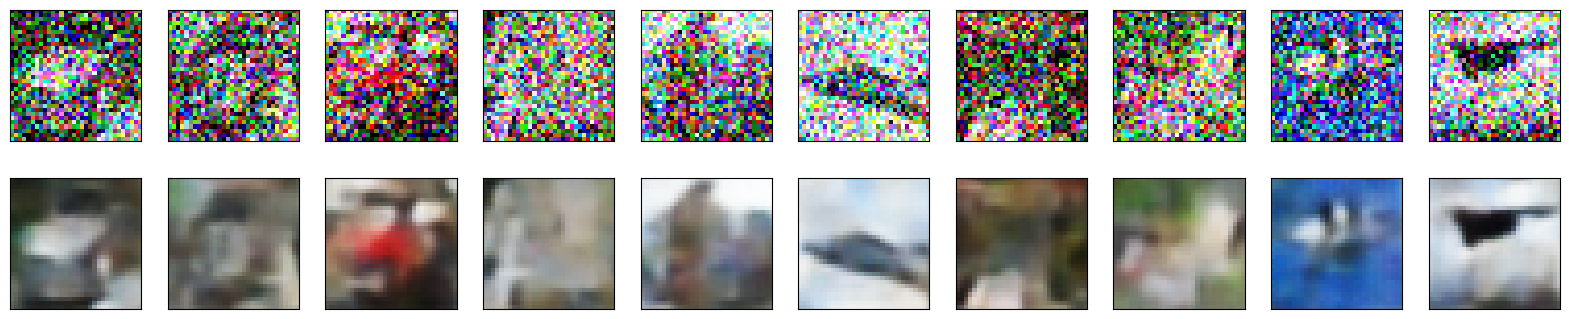

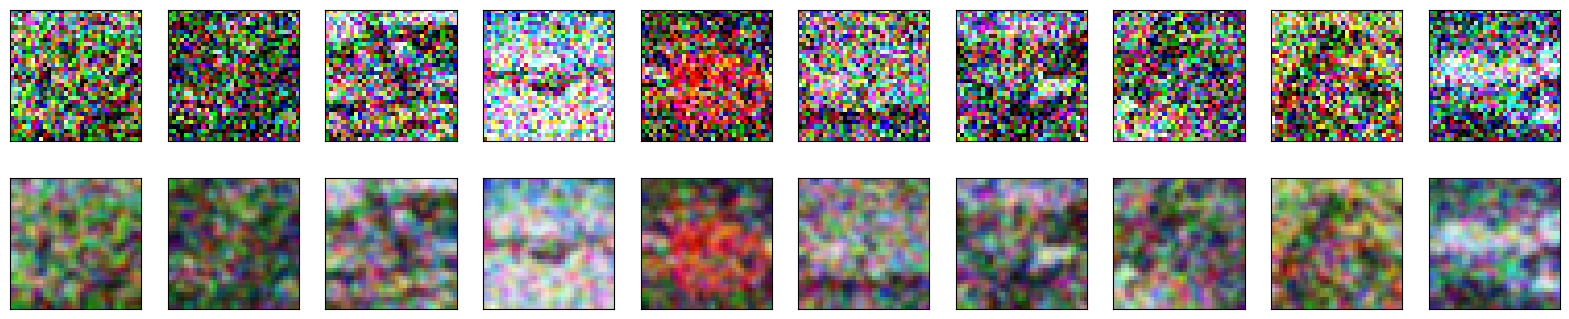

Dropout Autoencoder MSE: 0.00923637393862009
Gaussian Filter MSE: 0.020629242757988924


In [19]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

### Seventh iteration result 
Results are worse than Adam optimizer.

In [21]:
from keras.optimizers import SGD

# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=SGD(), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=25, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 16, 16, 32)       9248

313/313 [==============================] - 2s 7ms/step


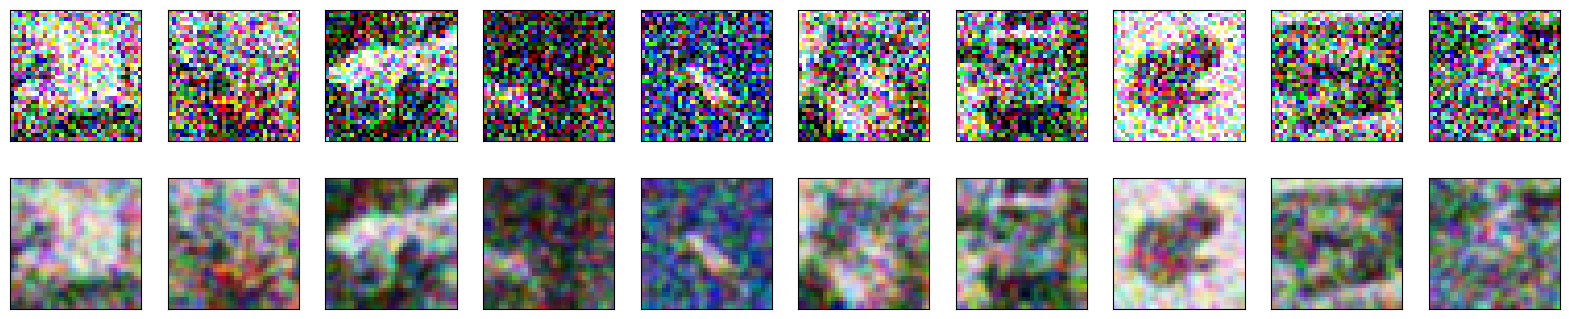

Dropout Autoencoder MSE: 0.025832444429397583
Gaussian Filter MSE: 0.020629242757988924


In [22]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

In [8]:
# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=100, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       9248  

2024-08-01 11:02:30.792118: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


391/391 [==============================] - 86s 218ms/step - loss: 0.5932 - val_loss: 0.5789
Epoch 2/100
391/391 [==============================] - 64s 165ms/step - loss: 0.5768 - val_loss: 0.5765
Epoch 3/100
391/391 [==============================] - 64s 164ms/step - loss: 0.5751 - val_loss: 0.5752
Epoch 4/100
391/391 [==============================] - 54s 138ms/step - loss: 0.5740 - val_loss: 0.5745
Epoch 5/100
391/391 [==============================] - 59s 151ms/step - loss: 0.5733 - val_loss: 0.5743
Epoch 6/100
391/391 [==============================] - 73s 186ms/step - loss: 0.5729 - val_loss: 0.5738
Epoch 7/100
391/391 [==============================] - 61s 157ms/step - loss: 0.5724 - val_loss: 0.5739
Epoch 8/100
391/391 [==============================] - 63s 162ms/step - loss: 0.5722 - val_loss: 0.5727
Epoch 9/100
391/391 [==============================] - 69s 177ms/step - loss: 0.5719 - val_loss: 0.5727
Epoch 10/100
391/391 [==============================] - 47s 120ms/step - los

313/313 [==============================] - 2s 7ms/step


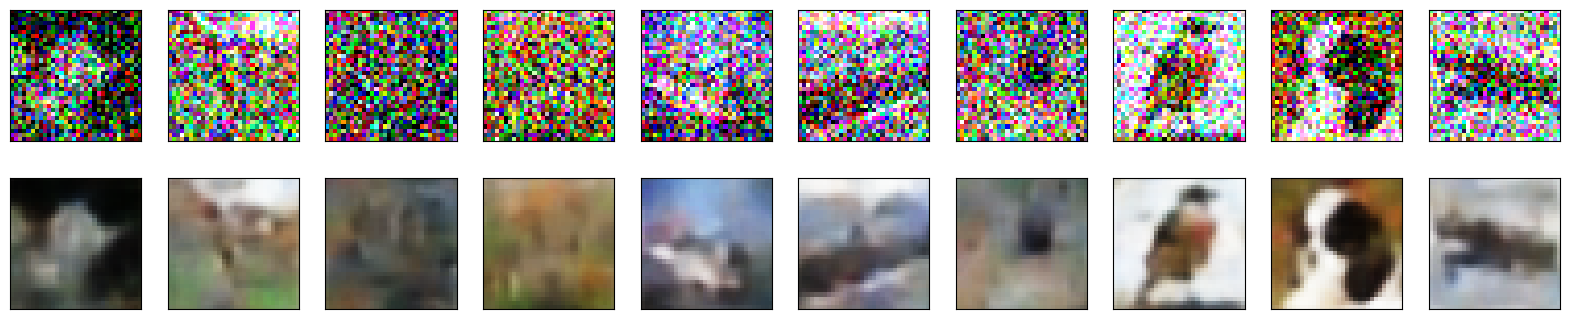

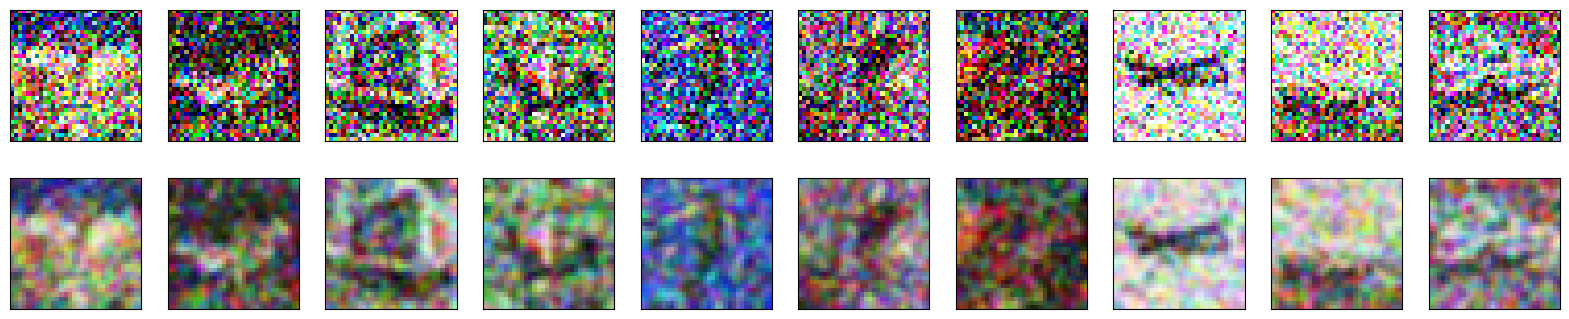

Dropout Autoencoder MSE: 0.008259126916527748
Gaussian Filter MSE: 0.020642591797581843


In [11]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

In [25]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.6
    noisy_array = array + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape)
    return np.clip(noisy_array, 0.0, 1.0)

In [26]:
# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

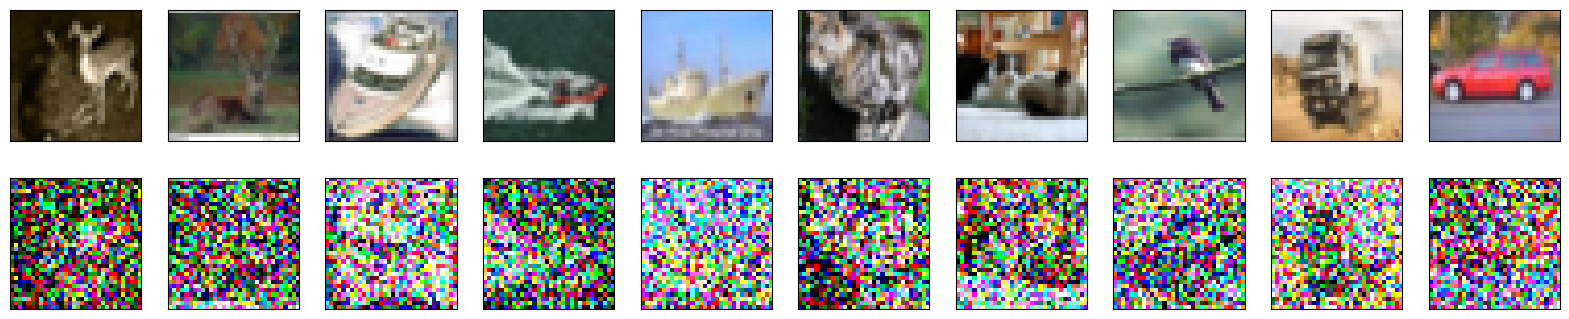

In [27]:
# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [20]:
# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=30, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 32)       9248

In [21]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

313/313 [==============================] - 3s 9ms/step


Dropout Autoencoder MSE: 0.01296000275760889
Gaussian Filter MSE: 0.03414852498822803


In [28]:
# Define the improved autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=30, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128 

313/313 [==============================] - 4s 12ms/step


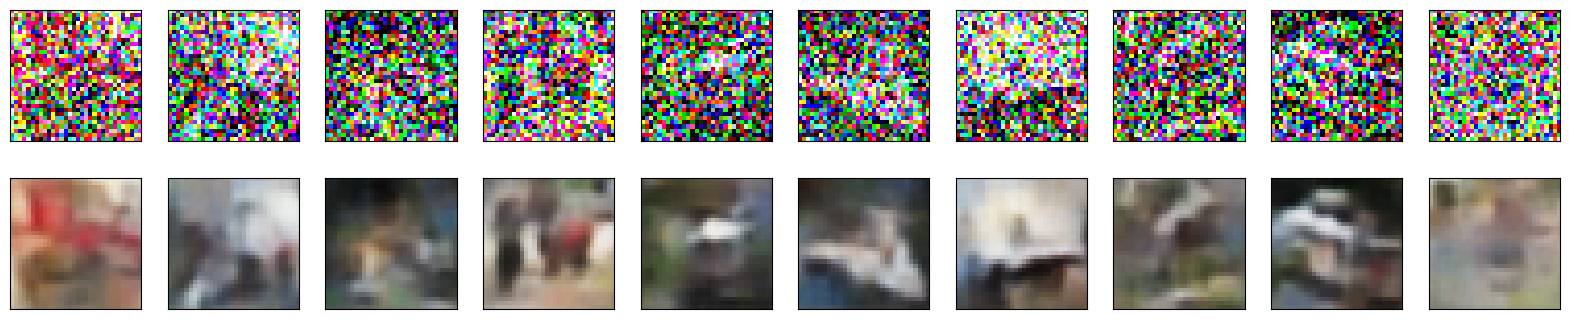

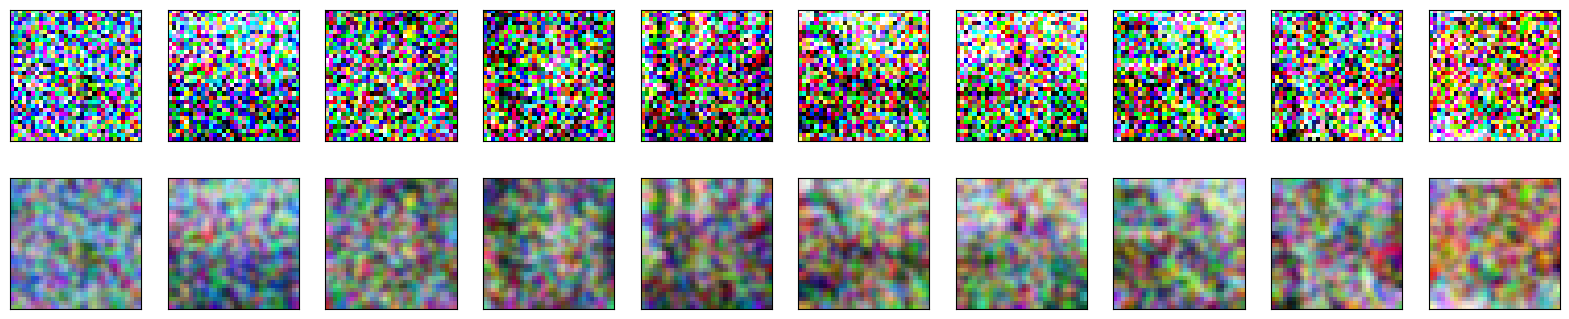

Dropout Autoencoder MSE: 0.01234477013349533
Gaussian Filter MSE: 0.034140364545129476


In [29]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

In [30]:
# Define the improved autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=45, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 32)       128 

313/313 [==============================] - 3s 10ms/step


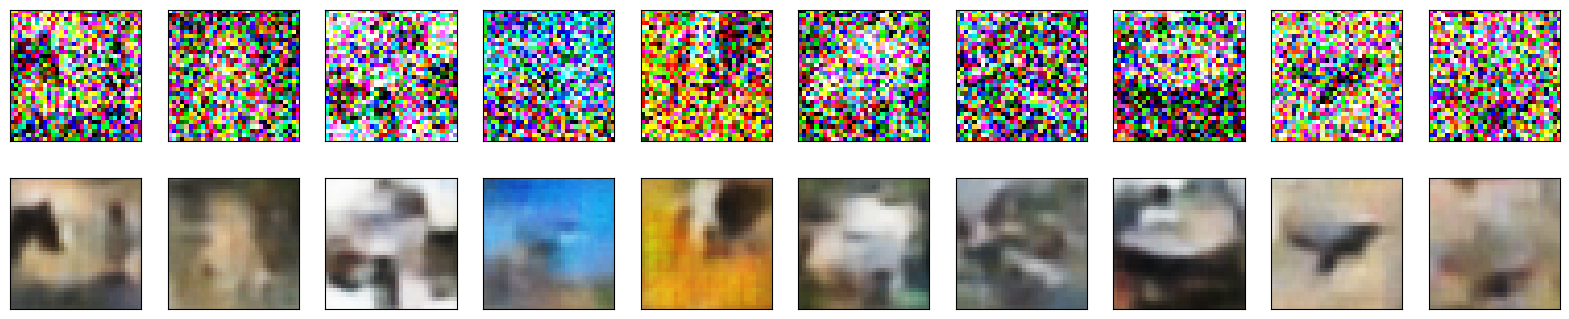

Dropout Autoencoder MSE: 0.012101373635232449
Gaussian Filter MSE: 0.034140364545129476


In [31]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

In [32]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape)
    return np.clip(noisy_array, 0.0, 1.0)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [23]:
# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=30, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 32)       9248

313/313 [==============================] - 3s 8ms/step


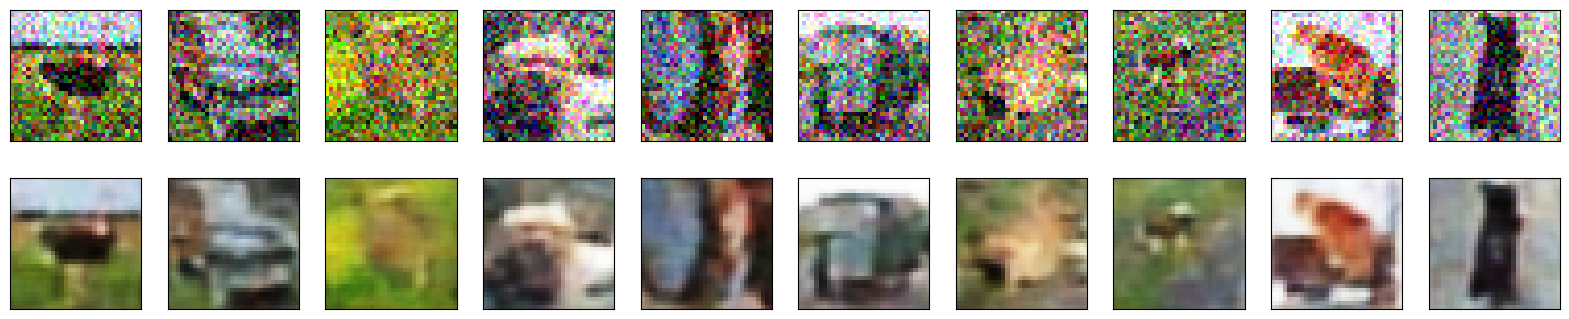

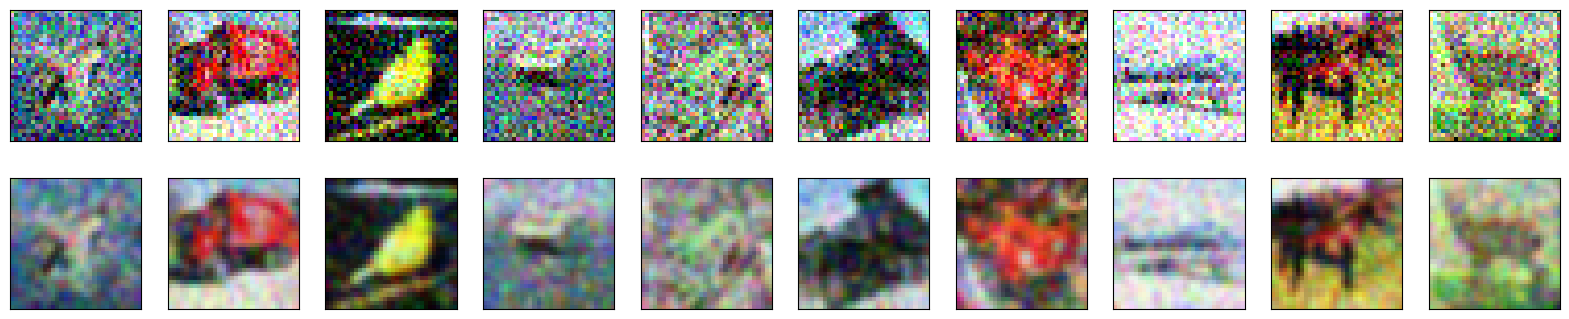

Dropout Autoencoder MSE: 0.004931209143251181
Gaussian Filter MSE: 0.007586701147956427


In [24]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

In [33]:
# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=60, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 16, 16, 32)       9248

313/313 [==============================] - 3s 10ms/step


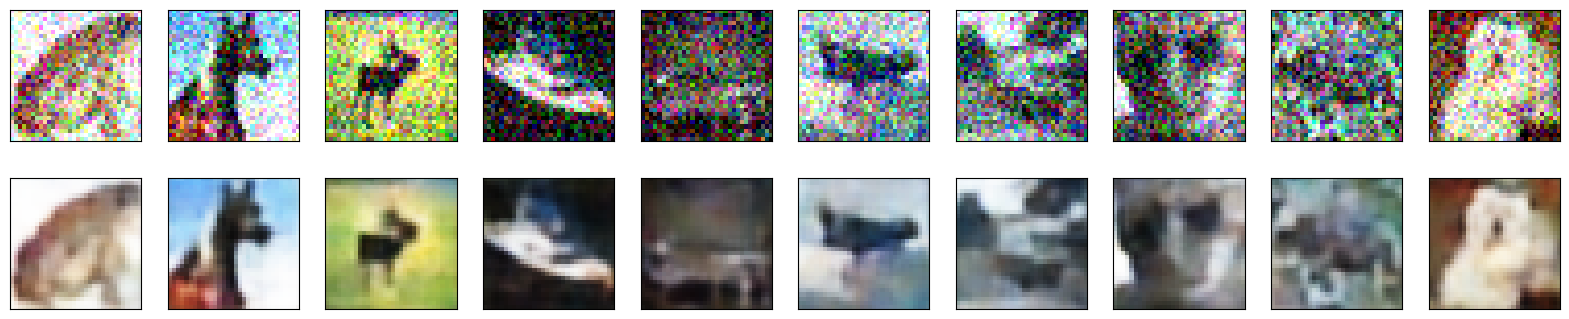

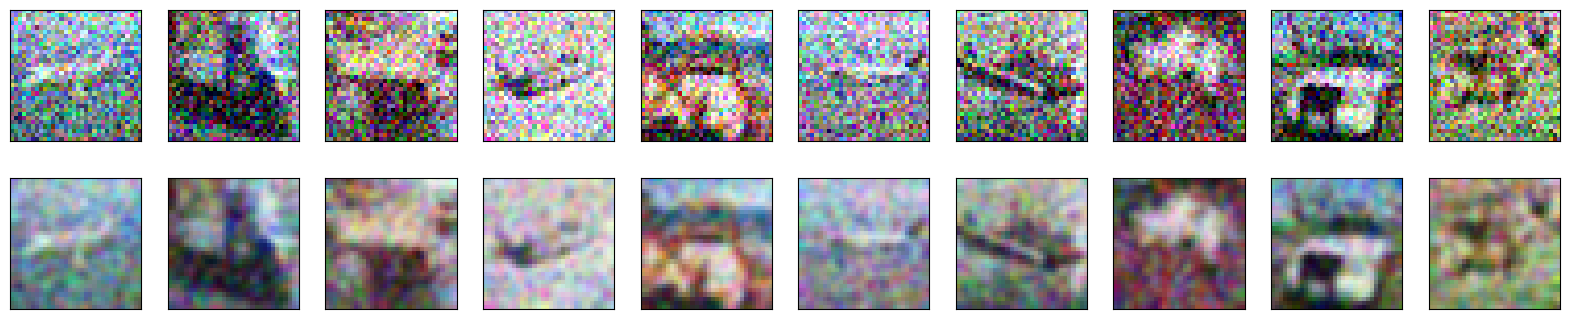

Dropout Autoencoder MSE: 0.004582560621201992
Gaussian Filter MSE: 0.007580400298368091


In [34]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")

In [35]:
# Define the autoencoder model
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_train_data, train_data, epochs=100, batch_size=128, shuffle=True, validation_data=(noisy_test_data, test_data))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 16, 16, 32)       9248

313/313 [==============================] - 3s 8ms/step


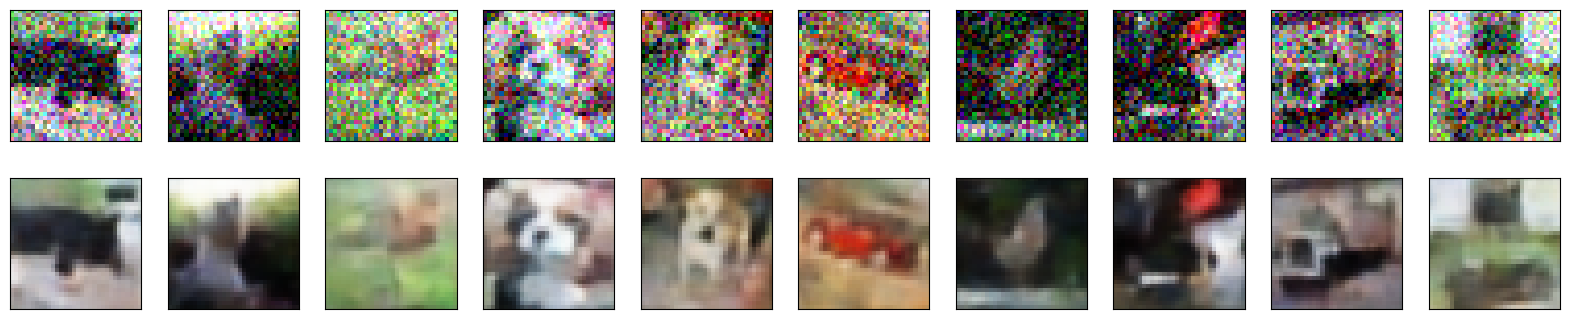

Dropout Autoencoder MSE: 0.004490341525524855
Gaussian Filter MSE: 0.007580400298368091


In [36]:
# Make predictions with the autoencoder
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Apply Gaussian filtering
gaussian_predictions = gaussian_denoise(noisy_test_data)
display(noisy_test_data, gaussian_predictions)

# Compare performance
autoencoder_mse = mean_squared_error(test_data.flatten(), predictions.flatten())
gaussian_mse = mean_squared_error(test_data.flatten(), gaussian_predictions.flatten())

print(f"Dropout Autoencoder MSE: {autoencoder_mse}")
print(f"Gaussian Filter MSE: {gaussian_mse}")